In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision.datasets import Caltech101
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from torchvision import models

In [ ]:
from torchvision.transforms import Lambda
from torch.utils.data import Subset, random_split

root = './data'

caltech101 = Caltech101(root, download=True)

# Define the custom transform to convert grayscale images to RGB
def grayscale_to_rgb(image):
    if image.mode == 'L':  
        image = image.convert('RGB') 
    return image

train_transform = transforms.Compose([
    Lambda(grayscale_to_rgb),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transform = transforms.Compose([
      Lambda(grayscale_to_rgb),
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
      Lambda(grayscale_to_rgb),
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# caltech101 = Caltech101(root, transform = test_transform, download=True)

# Split the dataset into train and test sets
train_size = int(0.7 * len(caltech101))
validation_size = int(0.15 * len(caltech101))
test_size = test_size = len(caltech101) - train_size - validation_size

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(caltech101, [train_size,validation_size, test_size])
#train_dataset, test_dataset = torch.utils.data.random_split(caltech101, [train_size, test_size])
# apply transformation to the data
class TransformedSubset(Subset):
    def __init__(self, dataset, indices, transform=None):
        super(TransformedSubset, self).__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        if self.transform:
            x = self.transform(x)
        return x, y


# apply transformation to the data
train_dataset = TransformedSubset(train_dataset.dataset, train_dataset.indices, transform=train_transform)
validation_dataset = TransformedSubset(validation_dataset.dataset, validation_dataset.indices, transform=validation_transform)
test_dataset = TransformedSubset(test_dataset.dataset, test_dataset.indices, transform=test_transform)


# Define the data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


131740031it [00:04, 32443547.61it/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


14028800it [00:00, 51975090.52it/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


In [ ]:
import numpy as np
import random

seed = 20  
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# Load the pre-trained ResNet50 model
net = models.resnet50(pretrained=True)

num_classes = 101
net.fc = nn.Linear(net.fc.in_features, num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

def train(net, dataloader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / (i + 1)


def validate(net, dataloader, criterion, device):
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / (i + 1), correct / total

# Train the model

num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(net, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(net, validation_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Finished Training")


Epoch 1/10, Train Loss: 2.7992, Validation Loss: 1.5460, Validation Accuracy: 0.7148
Epoch 2/10, Train Loss: 1.1073, Validation Loss: 0.5899, Validation Accuracy: 0.8793
Epoch 3/10, Train Loss: 0.5213, Validation Loss: 0.3222, Validation Accuracy: 0.9308
Epoch 4/10, Train Loss: 0.3070, Validation Loss: 0.2208, Validation Accuracy: 0.9554
Epoch 5/10, Train Loss: 0.2201, Validation Loss: 0.1835, Validation Accuracy: 0.9593
Epoch 6/10, Train Loss: 0.1570, Validation Loss: 0.1584, Validation Accuracy: 0.9654
Epoch 7/10, Train Loss: 0.1255, Validation Loss: 0.1472, Validation Accuracy: 0.9616
Epoch 8/10, Train Loss: 0.0986, Validation Loss: 0.1322, Validation Accuracy: 0.9708
Epoch 9/10, Train Loss: 0.0790, Validation Loss: 0.1218, Validation Accuracy: 0.9693
Epoch 10/10, Train Loss: 0.0686, Validation Loss: 0.1184, Validation Accuracy: 0.9700
Finished Training


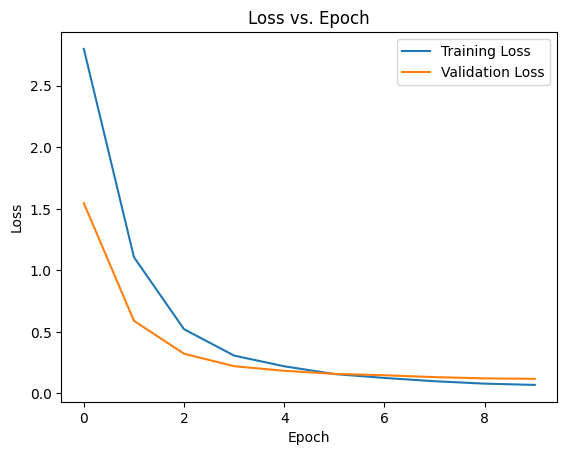

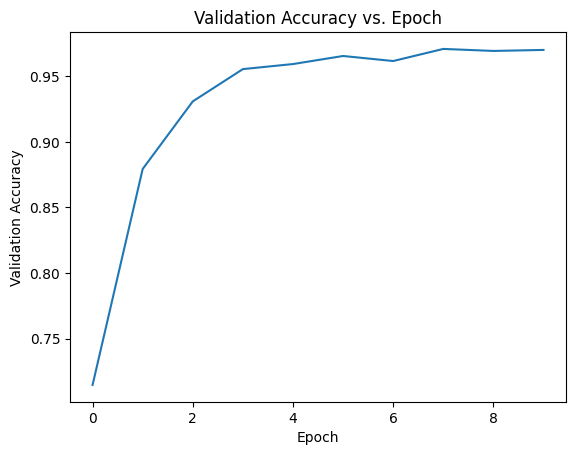

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

# Plot the validation accuracy
plt.figure()
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epoch')

plt.show()

In [ ]:
# Test the model
true_labels = []
predicted_labels = []

net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy * 100}%")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 95.62547966231773%
F1 score: 0.9548977890573814
Precision: 0.9631377902301278
Recall: 0.9562547966231773
